In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import warnings

In [2]:
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

In [3]:
df = pd.read_csv("processed/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv")

In [4]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734,0.0,2624734,2624734,9058214.0,0.0,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0,0.0,0,0,0.0,0.0,0,0,Benign


In [5]:
df["Label"].value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: count, dtype: int64

In [6]:
df = df[df["Label"] != "Label"]

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048574 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Dst Port           1048574 non-null  object
 1   Protocol           1048574 non-null  object
 2   Timestamp          1048574 non-null  object
 3   Flow Duration      1048574 non-null  object
 4   Tot Fwd Pkts       1048574 non-null  object
 5   Tot Bwd Pkts       1048574 non-null  object
 6   TotLen Fwd Pkts    1048574 non-null  object
 7   TotLen Bwd Pkts    1048574 non-null  object
 8   Fwd Pkt Len Max    1048574 non-null  object
 9   Fwd Pkt Len Min    1048574 non-null  object
 10  Fwd Pkt Len Mean   1048574 non-null  object
 11  Fwd Pkt Len Std    1048574 non-null  object
 12  Bwd Pkt Len Max    1048574 non-null  object
 13  Bwd Pkt Len Min    1048574 non-null  object
 14  Bwd Pkt Len Mean   1048574 non-null  object
 15  Bwd Pkt Len Std    1048574 non-null  object
 16  Flow 

In [8]:
df.isin(["Infinity", "-Infinity"]).sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

In [9]:
df_processed  = df[df['Label'].isin(['Benign', 'DoS attacks-Hulk'])].sample(100000, random_state=42).copy()

In [10]:
df_processed = df_processed.drop(['Dst Port', 'Protocol', 'Timestamp'], axis=1)
df_y = df_processed['Label'].copy() # Extract the Label column
df_x = df_processed.drop('Label', axis=1).copy() # Extract all other columns as features
df_y_binary = df_y.apply(lambda x: 0 if x == 'Benign' else 1)

In [11]:
# Convert features to numeric
for col in df_x.columns:
    df_x[col] = pd.to_numeric(df_x[col], errors='coerce')

In [12]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_x)

In [13]:
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

In [14]:
# Cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
print("Cumulative explained variance ratio:", cumulative_variance_ratio)

Cumulative explained variance ratio: [0.38494314 0.57243956 0.64964092 0.7155048  0.76408271 0.80919652
 0.8403255  0.87107667 0.89412842 0.9151542  0.93232756 0.94758707
 0.96268439]


In [15]:
k = 26
nbrs = NearestNeighbors(n_neighbors=k)
nbrs.fit(df_pca)
distances, _ = nbrs.kneighbors(df_pca)
distances = np.sort(distances[:, k - 1])

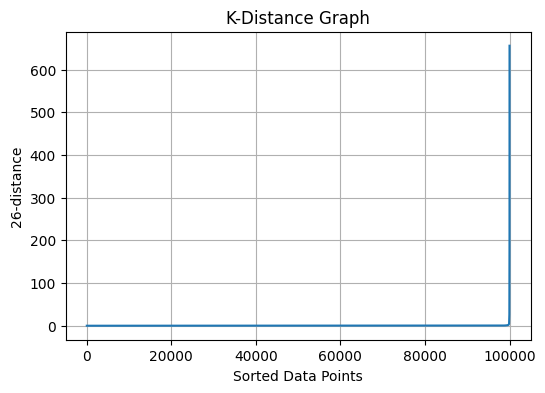

In [16]:
plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.ylabel(f"{k}-distance")
plt.xlabel("Sorted Data Points")
plt.title("K-Distance Graph")
plt.grid(True)
plt.show()

In [17]:
db = DBSCAN(eps=0.5, min_samples=k)
labels = db.fit_predict(df_pca)

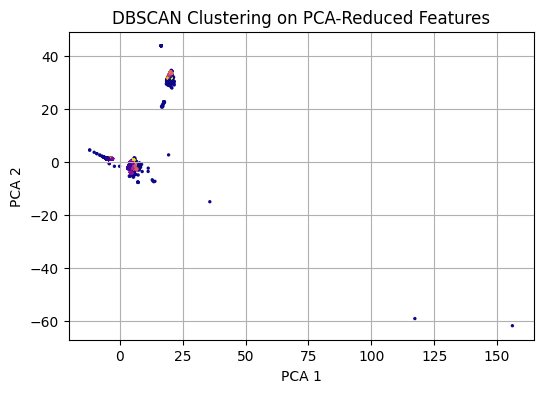

In [18]:
plt.figure(figsize=(6, 4))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='plasma', s=2)
plt.title("DBSCAN Clustering on PCA-Reduced Features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

In [19]:
y_pred_binary = np.where(labels == -1, 1, 0) # Predicted 1 for Anomaly, 0 for Normal
print("Adjusted Rand Index (ARI):", adjusted_rand_score(df_y_binary, y_pred_binary))

print(classification_report(df_y_binary, y_pred_binary, target_names=['Normal', 'Anomaly'], zero_division=0))



Adjusted Rand Index (ARI): 0.0001654146085402957
              precision    recall  f1-score   support

      Normal       0.49      0.99      0.65     48971
     Anomaly       0.41      0.01      0.02     51029

    accuracy                           0.49    100000
   macro avg       0.45      0.50      0.33    100000
weighted avg       0.45      0.49      0.33    100000

